<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据" data-toc-modified-id="数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据</a></span></li><li><span><a href="#模型" data-toc-modified-id="模型-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>模型</a></span></li><li><span><a href="#实验测试" data-toc-modified-id="实验测试-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>实验测试</a></span></li><li><span><a href="#test---递归多步预测" data-toc-modified-id="test---递归多步预测-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>test - 递归多步预测</a></span></li><li><span><a href="#随时间推进的递归多步验证" data-toc-modified-id="随时间推进的递归多步验证-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>随时间推进的递归多步验证</a></span></li><li><span><a href="#参考" data-toc-modified-id="参考-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>参考</a></span></li></ul></div>

参考 [姜振豪2018] 关于 **递归多步预测** 的结论，这里选用单步模型来验证多元方法在三维混沌系统上建模的优势. 


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import math
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 数据

In [2]:
### read data
dataroot = 'chen_lsoda002.csv'  # 'lorenz_lsoda002.csv' # 
data = pd.read_csv(dataroot, index_col=0)

### hyper-parameters setting for data prep
trn_r, val_r = 0.7, 0.2
input_window = timesteps = 10 # 16 # 20
output_window = prediction_horizon = 1 #
n_timeseries = data.shape[1] # 序列条数，变量个数
batch_size = bs = 16 # batch_size

In [3]:
##### data prep for multi-vars #####
seq_len = len(data)
train_length = int(seq_len*trn_r)
val_length = int(seq_len*val_r)
test_length = seq_len - train_length - val_length

### Windowing: time series data -> TS dataset (X, y) for supervised learning
X = np.zeros((seq_len, timesteps, n_timeseries))
y = np.zeros((seq_len, prediction_horizon, n_timeseries))

for i, name in enumerate(list(data.columns)):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")
    for k in range(prediction_horizon):
        y[:, k, i] = data[name].shift(-prediction_horizon).fillna(method="ffill").values

X = X[timesteps:]
y = y[timesteps:]

### train, val, test split of X, y, target
X_train = X[:train_length]
y_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_val = y[train_length:train_length+val_length]
X_test = X[-test_length:]
y_test = y[-test_length:]

### min-max scale transform of X, y, target
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_train_max = y_train.max(axis=0)
y_train_min = y_train.min(axis=0)

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_train = (y_train - y_train_min) / (y_train_max - y_train_min)
y_val = (y_val - y_train_min) / (y_train_max - y_train_min)
y_test = (y_test - y_train_min) / (y_train_max - y_train_min)

### 2 torch
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

### Batching: dataset -> dataloader
data_train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=bs)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=bs)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=bs)

上面 data_train_loader 里的 shuffle 就是 MTGNN 里的 sampling 

## 模型

In [4]:
class CausalConv1d(nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(nn.Module):
    def __init__(self,in_channels=1,embedding_size=256,k=5):
        super(context_embedding,self).__init__()
        self.causal_convolution = CausalConv1d(in_channels,embedding_size,kernel_size=k)

    def forward(self,x):
        x = self.causal_convolution(x)
        return torch.tanh(x)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class ConvTrans(nn.Module): # TransformerTimeSeries
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self, input_window, output_window, num_nodes=1, feature_size=256, kernel_size=7, nhead=8, num_layers=3, dropout=0):
        super(ConvTrans,self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.input_embedding = context_embedding(in_channels=num_nodes, embedding_size=feature_size, k=kernel_size)
        self.pos_encoder = PositionalEncoding(feature_size)
#         self.positional_embedding = nn.Embedding(feature_size*2,feature_size)

        self.encode_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encode_layer, num_layers=num_layers)

        self.fc1 = nn.Linear(feature_size, num_nodes) # decoder
        self.fc2 = nn.Linear(input_window, output_window)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)

    def forward(self, src): #x,y,attention_masks
        
        # concatenate observed points and time covariate
        # (Batchsize*feature_size*n_time_points)
        # 这里的输入是一个二维矩阵--2*时间长度，具有两个特征，一个是当前的值，另一个是当前的时间（协变量）
#         z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
#         z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
#         positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
#         input_embedding = z_embedding+positional_embeddings

# The shape of the 2D attn_mask, (timesteps, timesteps)
#         timesteps = src.size(1)
        if self.src_mask is None or self.src_mask.size(1) != src.size(1):
            device = src.device
            mask = self._generate_square_subsequent_mask(src.size(1)).to(device)
            self.src_mask = mask

# bs = 64, seq_len = 10, emb_sz = 256
#         print(src.size())# torch.Size([64, 10, 1])
#         self.pos_encoder(src)#.permute(0,2,1)
#         src_pe = torch.stack([self.pos_encoder(src[:,:,[i]]) for i in range(src.size(2))], dim=-1) # 不需要新的维度
        src_pe = self.pos_encoder(src[:,:,[0]]) # 取一个就好
#         print(src_pe.size())# torch.Size([64, 10, 256])
        src_ce = self.input_embedding(src.permute(0,2,1))
#         print(src_ce.size())# torch.Size([64, 256, 10])
        src_embedding = src_pe.permute(1,0,2) + src_ce.permute(2,0,1)
        # src_embedding torch.Size([10, 64, 256])
        transformer_embedding = self.transformer_encoder(src_embedding, self.src_mask).permute(1,0,2)
        # transformer_embedding torch.Size([64, 10, 256])
#         transformer_embedding = self.transformer_encoder(input_embedding,attention_masks)

        output = self.fc1(transformer_embedding) #
#         print(output.size()) # torch.Size([bs, seq_len, num_nodes])
        return self.fc2(output.permute(0,2,1)).permute(0,2,1)
# output.squeeze()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


## 实验测试

改改输入输出就行了

In [22]:
def run_experiment(
    model,
    model_name,
    model_file,
    epochs=150,
    loss=nn.MSELoss(),
    patience=10,
    must_train=False,
    val_again=True,
):
    try:
        model.load_state_dict(torch.load(model_file)) # 载入已有模型
        train = False
    except IOError: # FileNotFoundError, PermissionError
        train = True

    def validate(data_loader):
        with torch.no_grad(): # validating or testing
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in data_loader:
#                 batch_x = torch.unsqueeze(batch_x,dim=1)
#                 batch_x = batch_x.transpose(2,3)
                batch_y = batch_y.cuda()
                output = model(batch_x.cuda())
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y.squeeze()).item()*batch_x.shape[0] #.squeeze()
        return np.concatenate(preds).squeeze(), np.squeeze(np.concatenate(true)), mse_val

    if train or must_train:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

        ### model training, validating and saving the best ones
        min_val_loss = 9999
        counter = 0
        for j in range(epochs):
            mse_train = 0
            for batch_x, batch_y in data_train_loader:
#                 batch_x = torch.unsqueeze(batch_x,dim=1)
#                 batch_x = batch_x.transpose(2,3)
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                opt.zero_grad()
                y_pred = model(batch_x)
#                 print(batch_y.size())
#                 print(y_pred.size())
                y_pred = y_pred.squeeze(1)
#                 print(y_pred.size())
                l = loss(y_pred, batch_y.squeeze()) #.squeeze()
                l.backward()
                mse_train += l.item()*batch_x.shape[0]
                opt.step()
            epoch_scheduler.step()

            # validating
            preds, true, mse_val = validate(data_val_loader)

            if min_val_loss > mse_val**0.5: # saving 更小的验证集误差，最优模型
                min_val_loss = mse_val**0.5
                print("Saving...")
                torch.save(model.state_dict(), model_file) # 只保存训练好的权重
                counter = 0
            else: 
                counter += 1

            if counter == patience:
                break
            # print(f'Epoch:{j:3d}, train RMSE: {(mse_train/trn_r)**0.5:.4f}, val RMSE: {(mse_val/val_r)**0.5:.4f}')
            print(f'Epoch:{j:3d}, train MSE: {(mse_train):.4f}, val MSE: {(mse_val):.4f}')
            if(j % 10 == 0):
                preds = preds*(y_train_max[:] - y_train_min[:]) + y_train_min[:]
                true = true*(y_train_max[:] - y_train_min[:]) + y_train_min[:]
#                 print(preds.shape)
#                 print(true.shape)
                fig, axs = plt.subplots(n_timeseries, 1, sharex=True, figsize=(12,2*n_timeseries), dpi=85)
                fig.subplots_adjust(hspace=0) # Remove horizontal space between axes
                rmse = list(range(n_timeseries))
                mae = list(range(n_timeseries))
                for i in range(n_timeseries): # 验证集
                    rmse[i] = np.sqrt(mean_squared_error(true[:,i], preds[:,i]))
                    mae[i] = mean_absolute_error(true[:,i], preds[:,i])
                    axs[i].plot(true[:,i], label='Ground Truth')
                    axs[i].plot(preds[:,i], label=model_name) # Predicted
                    axs[i].legend()
                rmse_ = [f'{x:.3f}' for x in rmse]
                mae_ = [f'{x:.3f}' for x in mae]
                print(f'valid RMSE: {rmse_}, MAE: {mae_}')
                plt.show()
    
    print(f'==> Load the saved {model_name} model ...')
    model.load_state_dict(torch.load(model_file)) # 载入最优模型
    
    ### model testing
    preds2, true2, mse_val2 = validate(data_test_loader)

    ### inverse min-max scale transform
    preds2 = preds2*(y_train_max[:] - y_train_min[:]) + y_train_min[:]
    true2 = true2*(y_train_max[:] - y_train_min[:]) + y_train_min[:]
    
    fig2, axs2 = plt.subplots(n_timeseries, 1, sharex=True, figsize=(12,2*n_timeseries), dpi=85)
    fig2.subplots_adjust(hspace=0)

    ### evaluating some metrics
    rmse2 = list(range(n_timeseries))
    mae2 = list(range(n_timeseries))
    for i in range(n_timeseries):
#         print(preds2.shape)
#         print(true2.shape)
        rmse2[i] = np.sqrt(mean_squared_error(true2[:,i], preds2[:,i]))
        mae2[i] = mean_absolute_error(true2[:,i], preds2[:,i])
        axs2[i].plot(true2[:,i], label='Ground Truth')
        axs2[i].plot(preds2[:,i], label=model_name) # Predicted
        axs2[i].grid(ls='--')
        axs2[i].legend()
    rmse2_ = [f'{x:.3f}' for x in rmse2]
    mae2_ = [f'{x:.3f}' for x in mae2]
    print(f"{'x'*56}\n tset RMSE: {rmse2_}, MAE: {mae2_}")
    
    if val_again: # 再一次，验证集
        preds1, true1, mse_val1 = validate(data_val_loader)
        ### inverse min-max scale transform
        preds1 = preds1*(y_train_max[:] - y_train_min[:]) + y_train_min[:]
        true1 = true1*(y_train_max[:] - y_train_min[:]) + y_train_min[:]

        ### evaluating some metrics
        rmse1 = list(range(n_timeseries))
        mae1 = list(range(n_timeseries))
        for i in range(n_timeseries):
            rmse1[i] = np.sqrt(mean_squared_error(true1[:,i], preds1[:,i]))
            mae1[i] = mean_absolute_error(true1[:,i], preds1[:,i])
        rmse1_ = [f'{x:.3f}' for x in rmse1]
        mae1_ = [f'{x:.3f}' for x in mae1]
        print(f'valid RMSE: {rmse1_}, MAE: {mae1_}')
        rmse12 = [f'{x/y:.3f}' for x,y in zip(rmse1,rmse2)]
        mae12 = [f'{x/y:.3f}' for x,y in zip(mae1,mae2)]
        print(f'valid/test RMSE: {rmse12}, MAE: {mae12}')

    plt.show()

减小了 bs，为提高训练效能，模型太大，需要更多训练。合理的

==> Load the saved ConvTrans model ...
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
 tset RMSE: ['0.071', '0.095', '0.075'], MAE: ['0.056', '0.063', '0.052']
valid RMSE: ['0.077', '0.087', '0.074'], MAE: ['0.060', '0.064', '0.053']
valid/test RMSE: ['1.091', '0.923', '0.985'], MAE: ['1.069', '1.012', '1.020']


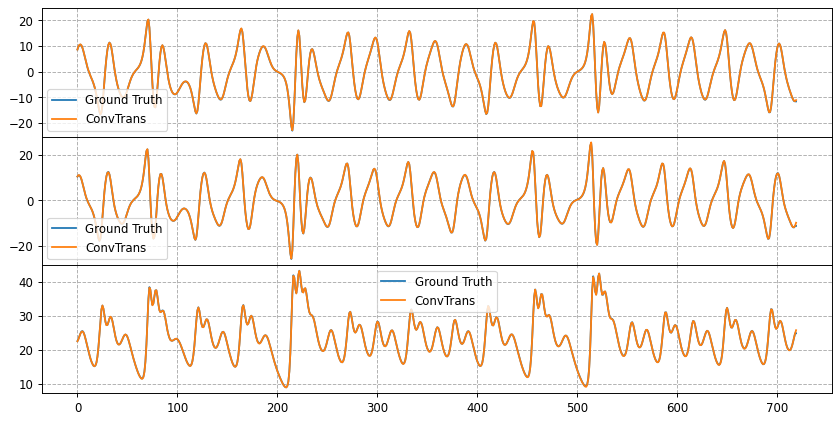

In [25]:
model = ConvTrans(input_window, output_window, num_nodes=n_timeseries, feature_size=256, kernel_size=9, nhead=8, num_layers=1, dropout=0).cuda()

run_experiment(model, model_name='ConvTrans', model_file='convtrans_m_chen0224.pt', epochs=250, patience=35) # , must_train=True, patience=20

## test - 递归多步预测

effective pred len

In [5]:
data_val_loader_rec = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=1)
data_test_loader_rec = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=1)

In [6]:
##### REC test #####
dt = 0.02
fontsize = 16
font = {'family': 'serif', 'size': fontsize}
error_bound = 1.5
linecolors1 = ['#457b9d','#fbc53e','#a71e34'] # 蓝，橙/黄，红
linecolors2 = ['#25abe2','#f99f1b','#ee446f']

def run_experiment_rec(
    model,
    model_name,
    model_file,
    N_plot=201,
    val_again=True,
):
    try:
        print(f'==> Load the saved {model_name} model ...')
        model.load_state_dict(torch.load(model_file)) # 载入已有模型
    except IOError: # FileNotFoundError, PermissionError
        print("model file not found, \n please use `run_experiment` to train first. ")
        return

    def validate_rec(data_loader_rec):
        with torch.no_grad(): # validating or testing
            preds = []
            true = []
            for k, (batch_x, batch_y) in enumerate(data_loader_rec):
                if k==0:
#                     batch_x = torch.unsqueeze(batch_x,dim=1)
#                     batch_x = batch_x.transpose(2,3)
                    batch_x_rec = batch_x[:]
                output = model(batch_x_rec.cuda())
                a = batch_x_rec[:,prediction_horizon:,:].clone()
                batch_x_rec[:,:-prediction_horizon,:] = a
                batch_x_rec[:,-prediction_horizon:,:] = output
#                 a = batch_x_rec[:,:,:,prediction_horizon:].clone()
#                 batch_x_rec[:,:,:,:-prediction_horizon] = a
#                 batch_x_rec[:,:,:,-prediction_horizon:] = output
                preds.append(output.squeeze(1).detach().cpu().numpy())
                true.append(batch_y.numpy())
#         return np.concatenate(preds).squeeze(), np.squeeze(np.concatenate(true))
        return np.concatenate(preds), np.squeeze(np.concatenate(true))

    def evaluate_rec(true0, preds0, linecolors, s='test'):
        ae = np.abs(preds0[:N_plot]-true0[:N_plot]) # 绝对误差
        cae = np.cumsum(ae, axis=0) # 累计绝对误差
        eff_pred_len = list(range(n_timeseries))

        fig, axs = plt.subplots(2*n_timeseries, 1, sharex=True, figsize=(12,2.5*n_timeseries), dpi=85)
        fig.subplots_adjust(hspace=0) # Remove horizontal space between axes
        for i in range(n_timeseries):
            cae_ = cae[:,i]
            eff_pred_len[i] = len(cae_[np.where(cae_ < error_bound)])
            axs[2*i].plot(np.array(range(N_plot))*dt, true0[:N_plot,i], color=linecolors[0], label='Ground Truth')
            axs[2*i].plot(np.array(range(N_plot))*dt, preds0[:N_plot,i], color=linecolors[1], label=model_name) # 
            axs[2*i].axvline(x=eff_pred_len[i]*dt, color="black", linestyle="--") # grey
            axs[2*i].grid(ls='-')
            axs[2*i].legend()
            axs[2*i+1].plot(np.array(range(N_plot))*dt, ae[:,i], color=linecolors[2]) # 红 
            axs[2*i+1].axhline(y=error_bound, color="black", linestyle="--")
            axs[2*i+1].grid(ls='-')
        axs[2*i+1].set_xlabel(r"Time $t$", **font)
        print(f"{model_name} gives a {*eff_pred_len,}-step effective prediction in {s} set ⇩")
        plt.show()

    if val_again: # 验证集
        preds1, true1 = validate_rec(data_val_loader_rec)
        ### inverse min-max scale transform
        preds1 = preds1*(y_train_max[:] - y_train_min[:]) + y_train_min[:]
        true1 = true1*(y_train_max[:] - y_train_min[:]) + y_train_min[:]

        ### evaluating
        evaluate_rec(true1, preds1, linecolors1, 'valid')
    
    ### model testing
    preds2, true2 = validate_rec(data_test_loader_rec)

    ### inverse min-max scale transform
    preds2 = preds2*(y_train_max[:] - y_train_min[:]) + y_train_min[:]
    true2 = true2*(y_train_max[:] - y_train_min[:]) + y_train_min[:]

    ### evaluating
    evaluate_rec(true2, preds2, linecolors2, 'test')

==> Load the saved ConvTrans model ...
ConvTrans gives a (10, 7, 9)-step effective prediction in valid set ⇩


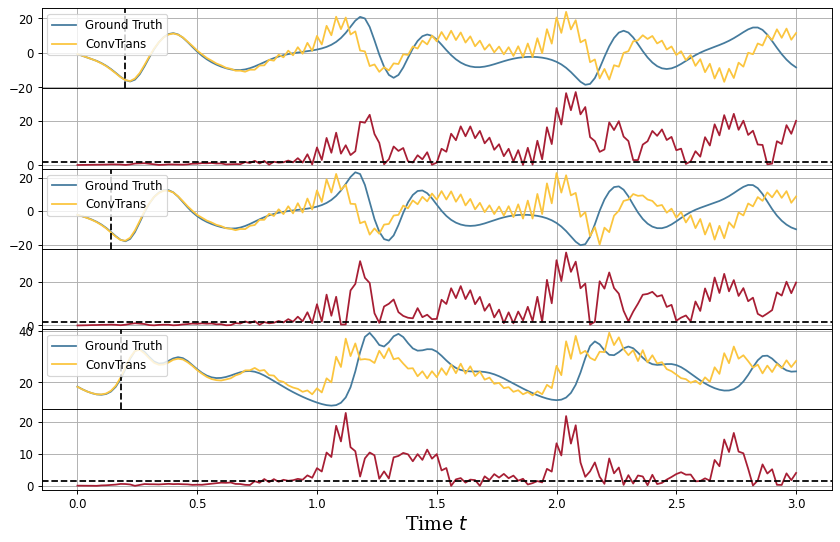

ConvTrans gives a (12, 9, 13)-step effective prediction in test set ⇩


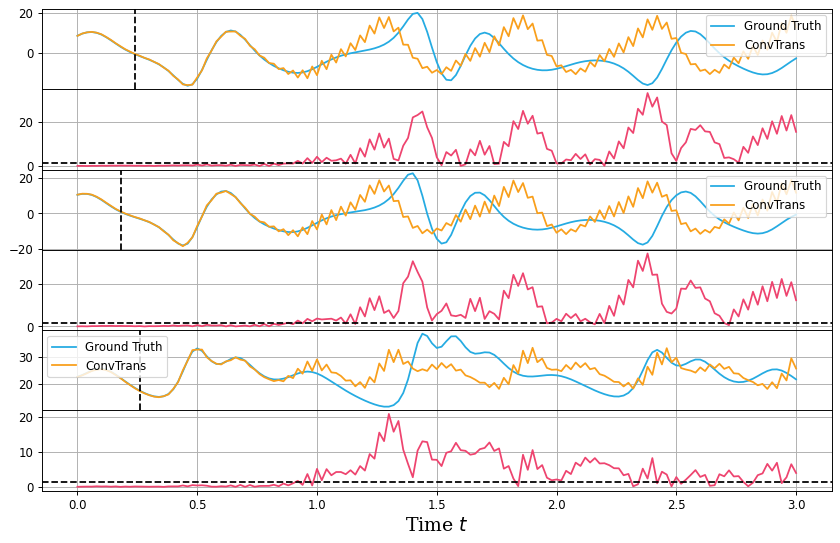

In [7]:
model = ConvTrans(input_window, output_window, num_nodes=n_timeseries, feature_size=256, kernel_size=9, nhead=8, num_layers=1, dropout=0).cuda()

run_experiment_rec(model, model_name='ConvTrans', model_file='convtrans_m_chen0224.pt', N_plot=151)

厉害喔


## 随时间推进的递归多步验证

递归多步预测的有效步数一般都不会超过 200 步（目前是这样，都还没有那么强的），

所以可以暂且用滑动的方式多次地测试取平均。如此得到的结果将更有说服力。


In [14]:
##### REC test n times #####
dt = 0.02
fontsize = 16
font = {'family': 'serif', 'size': fontsize}
error_bound = 1.5
linecolors1 = ['#457b9d','#fbc53e','#a71e34'] # 蓝，橙/黄，红
linecolors2 = ['#25abe2','#f99f1b','#ee446f']

def run_experiment_rec_n(
    model,
    model_name,
    model_file,
    N_plot=201,
    N_rec=100, # 递归多步预测的测试次数
    N_slide=3, # 相邻两次测试的步数差
    val_again=True,
):
    try:
        print(f'==> Load the saved {model_name} model ...')
        model.load_state_dict(torch.load(model_file)) # 载入已有模型
    except IOError: # FileNotFoundError, PermissionError
        print("model file not found, \n please use `run_experiment` to train first. ")
        return

    def validate_rec_n(data_loader_rec, N_start):
        with torch.no_grad(): # validating or testing
            preds = []
            true = []
            N_end = N_start + N_plot
            for k, (batch_x, batch_y) in enumerate(data_loader_rec):
                if k < N_start:
                    continue # 跳过当前继续执行下一个循环
                    # pass # 什么都不操作，接着循环
                    # break # 直接中断循环，不再执行
                elif k == N_start:
#                     batch_x = torch.unsqueeze(batch_x,dim=1)
#                     batch_x = batch_x.transpose(2,3)
                    batch_x_rec = batch_x[:]
                elif k >= N_end:
                    break
                output = model(batch_x_rec.cuda())
                a = batch_x_rec[:,prediction_horizon:,:].clone()
                batch_x_rec[:,:-prediction_horizon,:] = a
                batch_x_rec[:,-prediction_horizon:,:] = output
#                 a = batch_x_rec[:,:,:,prediction_horizon:].clone()
#                 batch_x_rec[:,:,:,:-prediction_horizon] = a
#                 batch_x_rec[:,:,:,-prediction_horizon:] = output
                preds.append(output.squeeze(1).detach().cpu().numpy())
                true.append(batch_y.numpy())
#         return np.concatenate(preds).squeeze(), np.squeeze(np.concatenate(true))
        return np.concatenate(preds), np.squeeze(np.concatenate(true))

    def evaluate_rec_n(true_, preds_, linecolors, s='test'):
        ### inverse min-max scale transform
        preds_ = [preds0*(y_train_max[:] - y_train_min[:]) + y_train_min[:] for preds0 in preds_]
        true_ = [true0*(y_train_max[:] - y_train_min[:]) + y_train_min[:] for true0 in true_]

        # N_rec_ = len(preds_) # 实际的测试次数
        ae_ = [np.abs(preds0[:]-true0[:]) for (preds0,true0) in zip(preds_,true_)]
        ae_n = np.average(ae_, axis=0) # 绝对误差的平均
        cae_n = np.cumsum(ae_n, axis=0)
        eff_pred_len_n = list(range(n_timeseries))

        preds0, true0 = preds_[-1], true_[-1] # 默认是最后一条作为样例
        N_plot0 = len(preds0)
        ae = np.abs(preds0[:]-true0[:]) # 绝对误差
        cae = np.cumsum(ae, axis=0) # 累计绝对误差
        eff_pred_len = list(range(n_timeseries))

        fig, axs = plt.subplots(2*n_timeseries, 1, sharex=True, figsize=(10,2.5*n_timeseries), dpi=85)
        fig.subplots_adjust(hspace=0) # Remove horizontal space between axes
        for i in range(n_timeseries):
            cae_ = cae[:,i]
            cae_i = cae_n[:,i]
            eff_pred_len[i] = len(cae_[np.where(cae_ < error_bound)])
            eff_pred_len_n[i] = len(cae_i[np.where(cae_i < error_bound)])
            axs[2*i].plot(np.array(range(N_plot0))*dt, true0[:,i], color=linecolors[0], label='Ground Truth')
            axs[2*i].plot(np.array(range(N_plot0))*dt, preds0[:,i], color=linecolors[1], label=model_name) # 
            axs[2*i].axvline(x=eff_pred_len[i]*dt, color="black", linestyle="--") # grey
            axs[2*i].grid(ls='-')
            axs[2*i].legend(loc="upper right")
            #(loc="upper left", bbox_to_anchor=(1,1)) # place legend in top right corner, legend()
            axs[2*i+1].plot(np.array(range(N_plot0))*dt, ae_n[:,i], color=linecolors[2], label='Averaged L1 Error') 
            axs[2*i+1].axhline(y=error_bound, color="black", linestyle="--")
            axs[2*i+1].grid(ls='-')
            axs[2*i+1].legend()
        axs[2*i+1].set_xlabel(r"Time $t$", **font)
        print(f"{model_name} gives a {*eff_pred_len,}-step effective prediction in {s} set ⇩\n{*eff_pred_len_n,}-step effective prediction on average")
        plt.show()

    if val_again: # 验证集
        preds1 = list(range(N_rec))
        true1 = list(range(N_rec))
        for j in range(N_rec):
            preds1[j], true1[j] = validate_rec_n(data_val_loader_rec, j*N_slide)

        ### evaluating
        evaluate_rec_n(true1, preds1, linecolors1, 'valid')
    
    ### model testing
    preds2 = list(range(N_rec))
    true2 = list(range(N_rec))
    for j in range(N_rec):
        preds2[j], true2[j] = validate_rec_n(data_test_loader_rec, j*N_slide)

    ### evaluating
    evaluate_rec_n(true2, preds2, linecolors2, 'test')

==> Load the saved ConvTrans model ...
ConvTrans gives a (13, 12, 14)-step effective prediction in valid set ⇩
(9, 8, 10)-step effective prediction on average


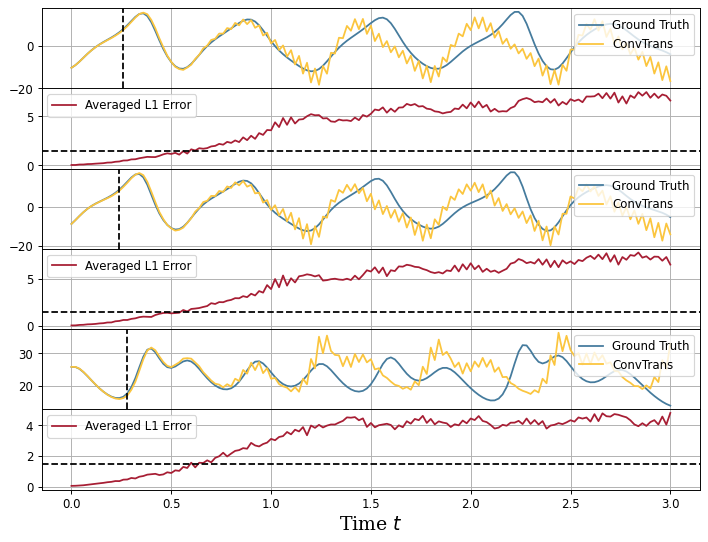

ConvTrans gives a (9, 7, 10)-step effective prediction in test set ⇩
(10, 8, 10)-step effective prediction on average


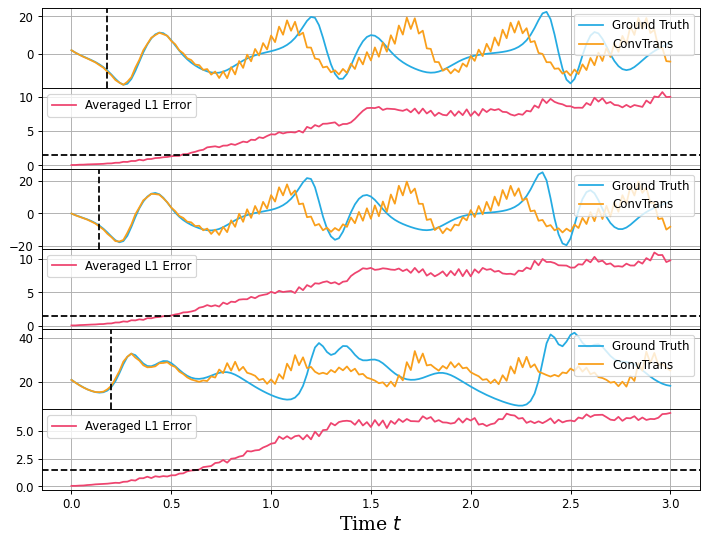

In [15]:
model = ConvTrans(input_window, output_window, num_nodes=n_timeseries, feature_size=256, kernel_size=9, nhead=8, num_layers=1, dropout=0).cuda()

run_experiment_rec_n(model, model_name='ConvTrans', model_file='convtrans_m_chen0224.pt', N_plot=151, N_rec=100, N_slide=4)

## 参考

[【python量化】将Transformer模型用于股票价格预测](https://mp.weixin.qq.com/s/o4iHwPwXKjmKPrE4Odcr3A)

ConvTransformer

